### Deep learning model training.


In [1]:
import torch
import glob
import time
import random
import torch.nn as nn
from torchsummary import summary
from model.model.unet import unet
from utils.dataloader import Dataset
from utils.imgShow import imsShow
from utils.acc_metric import oa_binary, miou_binary


### dataset loading

In [2]:
# ----------Data paths-------------- 
paths_truth = sorted(glob.glob('data/dset-l5789/truth/*.tif'))
paths_scene = [path_truth.replace('_truth.tif', '.tif').replace('truth','scene') 
                                                        for path_truth in paths_truth]
print(len(paths_scene))


76


In [3]:
tra_data = Dataset(paths_scene=paths_scene[7:], paths_truth=paths_truth[7:])
val_data = Dataset(paths_scene=paths_scene[0:7], paths_truth=paths_truth[0:7])
tra_loader = torch.utils.data.DataLoader(tra_data, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4)


#### Model training

In [4]:
### check model
model = unet(num_bands=6)
summary(model, input_size=(6,256,256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             880
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
         Upsample-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1, 64,

In [5]:
### create loss and optimizer
loss_bce = nn.BCELoss()     
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [6]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred = model(x)
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------train loops------'''
def train_loops(model, loss_fn, optimizer, tra_loader, 
                                    val_loader, epoches, device):
    model = model.to(device)
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0
        '''-----train the model-----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                    optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        '''-----validation the model-----'''
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, 
                                                    x=x_batch, y=y_batch)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()
        ## Accuracy
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        format = 'Ep{}: tra-> Loss:{:.3f},Oa:{:.2f},Miou:{:.2f}, val-> Loss:{:.2f},Oa:{:.2f},Miou:{:.2f},time:{:.0f}s'
        print(format.format(epoch+1, tra_loss, tra_oa, tra_miou, val_loss, val_oa, val_miou, time.time()-start))
        ## show the result
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_data))
            patch, truth = val_data[sam_index]
            patch, truth = torch.unsqueeze(patch, 0).to(device), truth.to(device)
            pred = model(patch)
            ## convert to numpy and plot
            patch = patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            imsShow([patch, truth, pred], 
                    img_name_list=['input_patch', 'truth', 'prediction'] , figsize=(10,4))


Ep1: tra-> Loss:0.510,Oa:0.68,Miou:0.52, val-> Loss:0.57,Oa:0.81,Miou:0.68,time:14s
Ep2: tra-> Loss:0.407,Oa:0.50,Miou:0.45, val-> Loss:0.19,Oa:0.86,Miou:0.69,time:13s
Ep3: tra-> Loss:0.309,Oa:0.84,Miou:0.70, val-> Loss:0.39,Oa:0.87,Miou:0.73,time:14s
Ep4: tra-> Loss:0.203,Oa:0.85,Miou:0.72, val-> Loss:0.21,Oa:0.94,Miou:0.63,time:14s
Ep5: tra-> Loss:0.204,Oa:0.87,Miou:0.77, val-> Loss:0.18,Oa:0.78,Miou:0.70,time:14s
Ep6: tra-> Loss:0.198,Oa:0.88,Miou:0.73, val-> Loss:0.26,Oa:0.88,Miou:0.77,time:14s
Ep7: tra-> Loss:0.138,Oa:0.88,Miou:0.81, val-> Loss:0.15,Oa:0.93,Miou:0.61,time:14s
Ep8: tra-> Loss:0.136,Oa:0.93,Miou:0.80, val-> Loss:0.20,Oa:0.92,Miou:0.83,time:14s
Ep9: tra-> Loss:0.139,Oa:0.90,Miou:0.82, val-> Loss:0.16,Oa:0.77,Miou:0.62,time:15s
Ep10: tra-> Loss:0.149,Oa:0.92,Miou:0.85, val-> Loss:0.17,Oa:0.90,Miou:0.83,time:17s


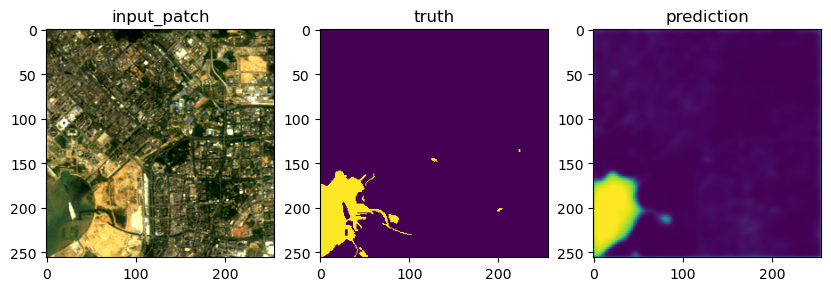

Ep11: tra-> Loss:0.133,Oa:0.87,Miou:0.78, val-> Loss:0.26,Oa:0.94,Miou:0.69,time:14s


In [ ]:
device = torch.device('cuda:0') 
train_loops(model=model, 
            loss_fn=loss_bce, 
            optimizer=optimizer,
            tra_loader=tra_loader, 
            val_loader=val_loader, 
            epoches=20,
            device=device)


In [ ]:
## model saving
# path_save = 'model/trained/unet_l5789.pth'
# torch.save(model.state_dict(), path_save)   # save weights of the trained model 
# model.load_state_dict(torch.load(path_save))  # load the weights of the trained model
